In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

from evaluation import evaluate_model
from preprocessing import *
from cross_validation import cross_validate_model
from sklearn import preprocessing

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_theme(
    style="whitegrid",       # Background style ("whitegrid", "darkgrid", etc.)
    palette="deep",          # Default color palette ("deep", "muted", "bright", etc.)
    font="sans-serif",       # Font family
    font_scale=1.1,          # Scale font size slightly
    rc={"figure.figsize": (8, 5)}  # Default figure size
)

c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = Path("../datasets")

train_identity = pd.read_csv(dataset_path / "train_identity.csv")
train_tx = pd.read_csv(dataset_path / "train_transaction.csv")

In [3]:
train_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')

X =  train_all_cols.drop(columns=['isFraud'])
y = train_all_cols['isFraud']

In [4]:
print(f"X_shape: {X.shape}")

X_shape: (590540, 433)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

In [6]:
X_train, X_test  = preprocess_datasets(X_train, X_test)

Dropping columns: ['id_23', 'id_21', 'V121', 'V107', 'id_24', 'V300', 'V110', 'V117', 'id_07', 'V122', 'V286', 'V116', 'V109', 'V113', 'V123', 'id_25', 'V311', 'V108', 'V111', 'id_08', 'V114', 'TransactionDT', 'V119', 'V115', 'id_26', 'id_22', 'V120', 'V301', 'id_27', 'V112', 'V118', 'V305', 'C3']
Train shape: (531486, 400)
Val shape: (59054, 400)


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

def evaluate_random_forest_estimators(X_train, y_train, X_val, y_val, estimator_range):
    val_f1_scores = []
    val_precision_scores = []
    val_recall_scores = []
    val_auc_scores = []

    train_f1_scores = []
    train_precision_scores = []
    train_recall_scores = []
    train_auc_scores = []

    for n in estimator_range:
        rf = RandomForestClassifier(
            n_estimators=n,
            random_state=42,
            n_jobs=-1,
            class_weight=class_weight_dict
        )
        rf.fit(X_train, y_train)

        # Validation Predictions
        y_val_pred_proba = rf.predict_proba(X_val)[:, 1]
        y_val_pred = (y_val_pred_proba > 0.5).astype(int)

        # Training Predictions
        y_train_pred_proba = rf.predict_proba(X_train)[:, 1]
        y_train_pred = (y_train_pred_proba > 0.5).astype(int)

        # Validation Metrics
        val_auc_scores.append(roc_auc_score(y_val, y_val_pred_proba))
        val_f1_scores.append(f1_score(y_val, y_val_pred))
        val_precision_scores.append(precision_score(y_val, y_val_pred))
        val_recall_scores.append(recall_score(y_val, y_val_pred))

        # Training Metrics
        train_auc_scores.append(roc_auc_score(y_train, y_train_pred_proba))
        train_f1_scores.append(f1_score(y_train, y_train_pred))
        train_precision_scores.append(precision_score(y_train, y_train_pred))
        train_recall_scores.append(recall_score(y_train, y_train_pred))

        print(f"n_estimators={n} => "
              f"[VAL] AUC: {val_auc_scores[-1]:.4f}, F1: {val_f1_scores[-1]:.4f}, "
              f"Precision: {val_precision_scores[-1]:.4f}, Recall: {val_recall_scores[-1]:.4f} | "
              f"[TRAIN] AUC: {train_auc_scores[-1]:.4f}, F1: {train_f1_scores[-1]:.4f}")

    # Plotting
    plt.figure(figsize=(16, 12))

    metrics = [
        ("AUC", train_auc_scores, val_auc_scores, 'blue'),
        ("F1 Score", train_f1_scores, val_f1_scores, 'green'),
        ("Precision", train_precision_scores, val_precision_scores, 'orange'),
        ("Recall", train_recall_scores, val_recall_scores, 'red'),
    ]

    for i, (title, train_scores, val_scores, color) in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(estimator_range, train_scores, marker='o', label='Train', linestyle='--', color=color)
        plt.plot(estimator_range, val_scores, marker='s', label='Validation', color=color)
        plt.title(f'{title} vs. n_estimators')
        plt.xlabel('Number of Estimators')
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "train": {
            "auc": train_auc_scores,
            "f1": train_f1_scores,
            "precision": train_precision_scores,
            "recall": train_recall_scores
        },
        "val": {
            "auc": val_auc_scores,
            "f1": val_f1_scores,
            "precision": val_precision_scores,
            "recall": val_recall_scores
        }
    }

In [ ]:
estimator_range = range(50, 200, 20) 
scores = evaluate_random_forest_estimators(X_train, y_train, X_test, y_test, estimator_range)

n_estimators=100 => [VAL] AUC: 0.9320, F1: 0.5786, Precision: 0.9462, Recall: 0.4167 | [TRAIN] AUC: 1.0000, F1: 0.9997
n_estimators=300 => [VAL] AUC: 0.9380, F1: 0.5782, Precision: 0.9441, Recall: 0.4167 | [TRAIN] AUC: 1.0000, F1: 1.0000
n_estimators=500 => [VAL] AUC: 0.9392, F1: 0.5797, Precision: 0.9443, Recall: 0.4182 | [TRAIN] AUC: 1.0000, F1: 1.0000
n_estimators=700 => [VAL] AUC: 0.9392, F1: 0.5743, Precision: 0.9405, Recall: 0.4134 | [TRAIN] AUC: 1.0000, F1: 1.0000
n_estimators=900 => [VAL] AUC: 0.9405, F1: 0.5762, Precision: 0.9408, Recall: 0.4153 | [TRAIN] AUC: 1.0000, F1: 1.0000


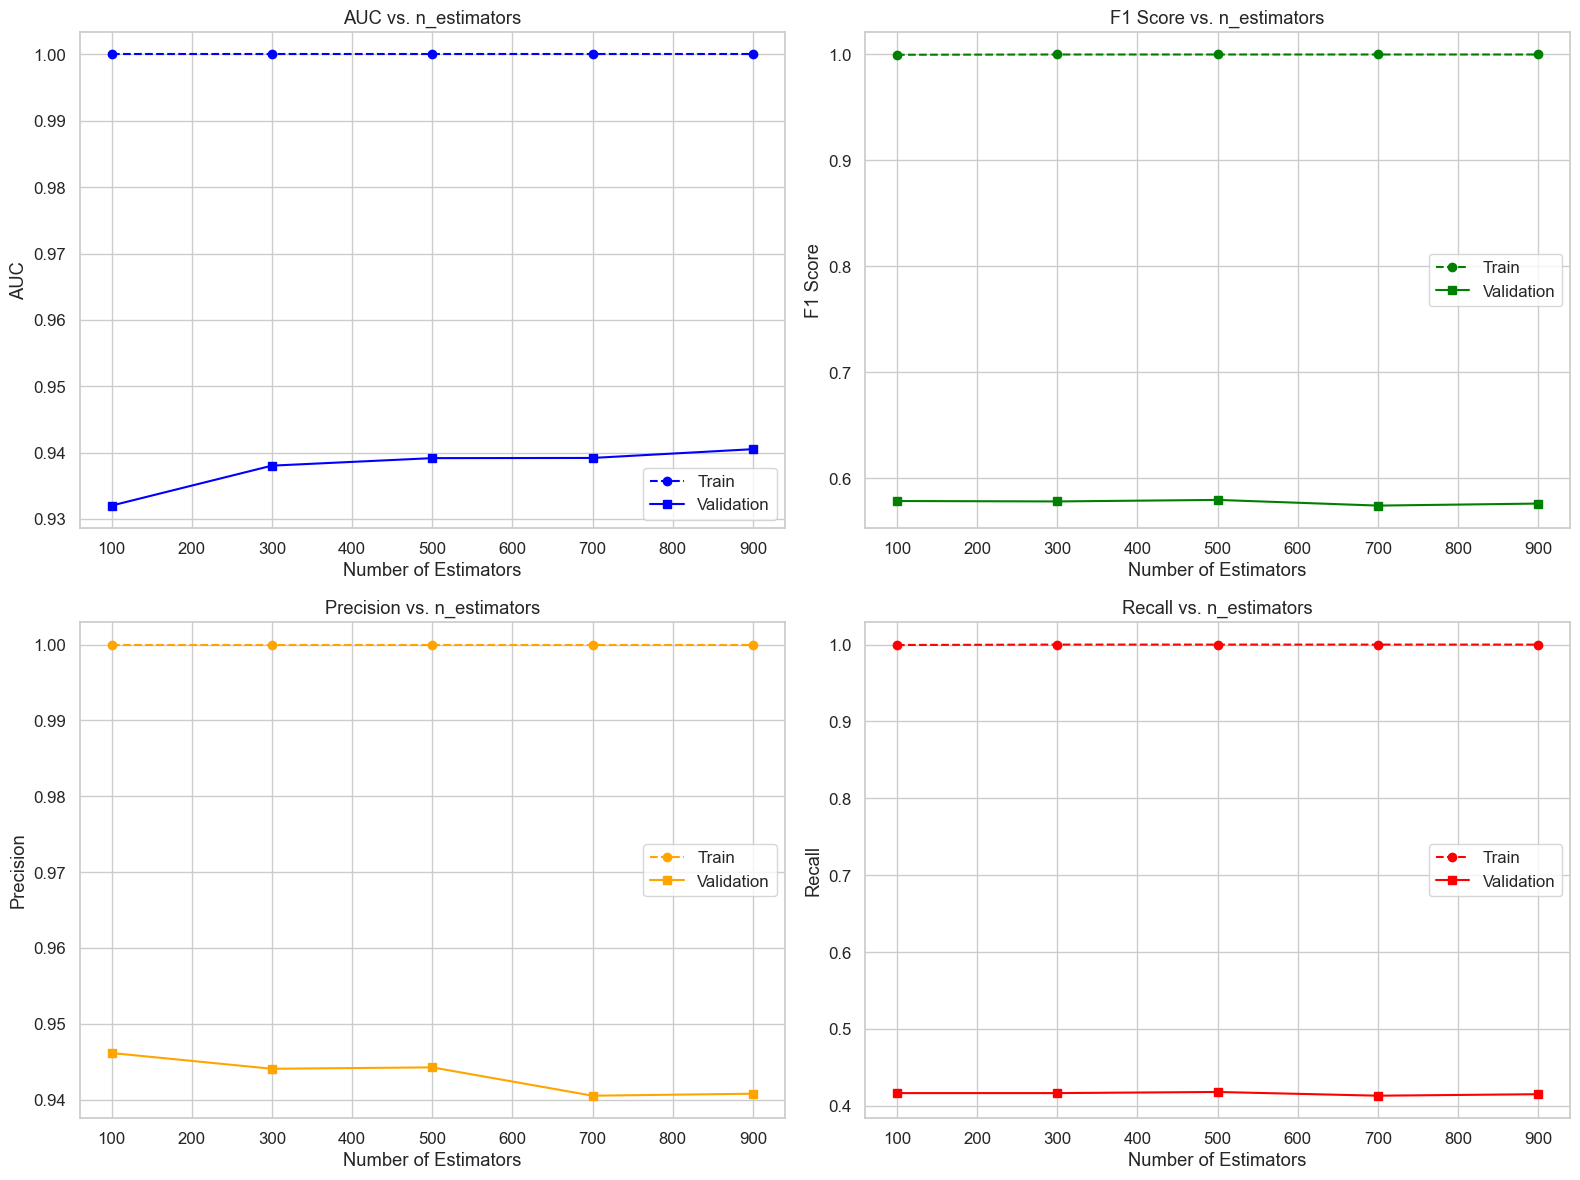

In [8]:
estimator_range = range(100, 1000, 200) 
scores = evaluate_random_forest_estimators(X_train, y_train, X_test, y_test, estimator_range)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Recompute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Define and train the model
model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, class_weight=class_weight_dict)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5181296537847371),
                                     np.int64(1): np.float64(14.289562832714955)},
                       n_estimators=500, n_jobs=-1, random_state=42)

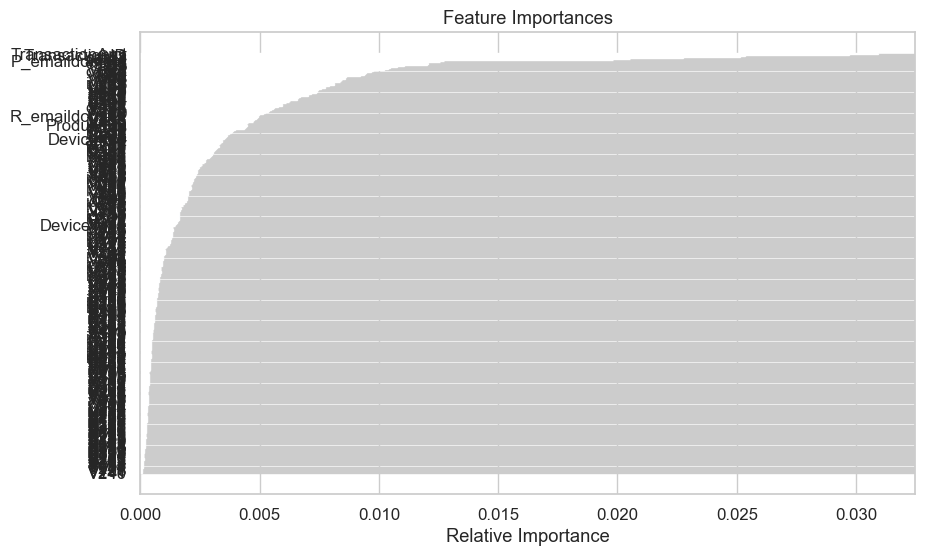

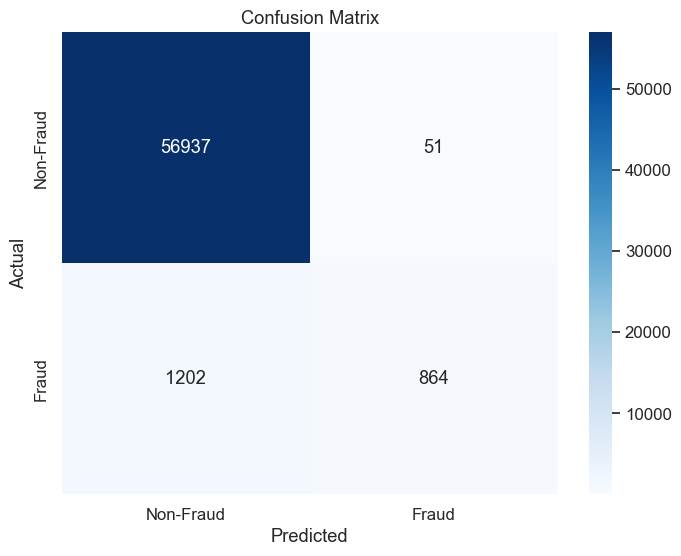

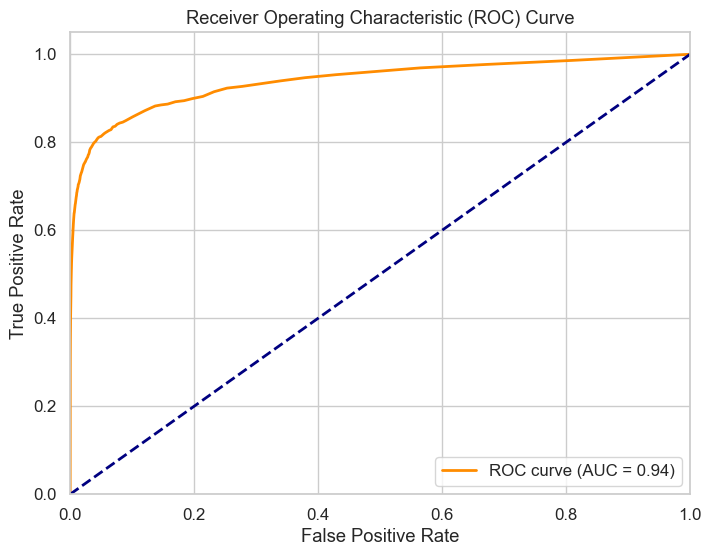

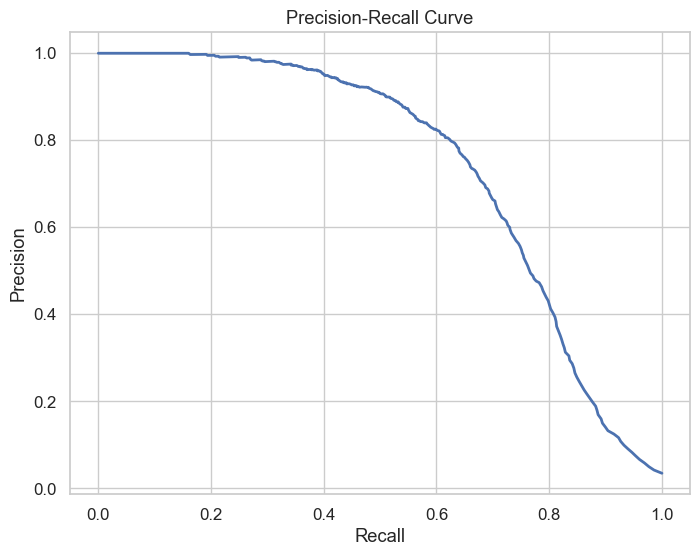

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve, validation_curve

def generate_rf_plots(model, X_train, y_train, X_test, y_test, param_name='max_depth', param_range=None):
    # Feature Importance Plot
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.barh(range(len(indices)), feature_importances[indices], align="center")
    plt.yticks(range(len(indices)), np.array(X_train.columns)[indices])
    plt.xlabel("Relative Importance")
    plt.show()

    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # ROC Curve
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="b", lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1)
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Training Score", color="b", lw=2)
    plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation Score", color="r", lw=2)
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

    # Validation Curve
    if param_range is not None:
        train_scores, test_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, n_jobs=-1)
        plt.figure(figsize=(8, 6))
        plt.plot(param_range, train_scores.mean(axis=1), label="Training Score", color="b", lw=2)
        plt.plot(param_range, test_scores.mean(axis=1), label="Validation Score", color="r", lw=2)
        plt.title(f"Validation Curve for {param_name}")
        plt.xlabel(param_name)
        plt.ylabel("Score")
        plt.legend(loc="best")
        plt.show()

    # Out-of-Bag (OOB) Error Plot (if applicable)
    if hasattr(model, 'oob_score_'):
        n_estimators_range = np.arange(1, 501, 50)
        oob_errors = []
        for n in n_estimators_range:
            model.set_params(n_estimators=n)
            model.fit(X_train, y_train)
            oob_errors.append(1 - model.oob_score_)
        
        plt.figure(figsize=(8, 6))
        plt.plot(n_estimators_range, oob_errors, label="OOB Error", color="g", lw=2)
        plt.title("OOB Error vs Number of Estimators")
        plt.xlabel("Number of Estimators")
        plt.ylabel("OOB Error")
        plt.legend(loc="best")
        plt.show()

# Example usage
generate_rf_plots(model, X_train, y_train, X_test, y_test, param_name='max_depth', param_range=np.arange(1, 21))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve, validation_curve

def generate_rf_plots(model, X_train, y_train, X_test, y_test, param_name='max_depth', param_range=None):
    # Feature Importance Plot
    # feature_importances = model.feature_importances_
    # indices = np.argsort(feature_importances)
    # plt.figure(figsize=(10, 6))
    # plt.title("Feature Importances")
    # plt.barh(range(len(indices)), feature_importances[indices], align="center")
    # plt.yticks(range(len(indices)), np.array(X_train.columns)[indices])
    # plt.xlabel("Relative Importance")
    # plt.show()

    # # Confusion Matrix
    # y_pred = model.predict(X_test)
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    # plt.title("Confusion Matrix")
    # plt.ylabel("Actual")
    # plt.xlabel("Predicted")
    # plt.show()

    # # ROC Curve
    # y_probs = model.predict_proba(X_test)[:, 1]
    # fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    # roc_auc = auc(fpr, tpr)
    # plt.figure(figsize=(8, 6))
    # plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
    # plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("Receiver Operating Characteristic (ROC) Curve")
    # plt.legend(loc="lower right")
    # plt.show()

    # # Precision-Recall Curve
    # precision, recall, _ = precision_recall_curve(y_test, y_probs)
    # plt.figure(figsize=(8, 6))
    # plt.plot(recall, precision, color="b", lw=2)
    # plt.xlabel("Recall")
    # plt.ylabel("Precision")
    # plt.title("Precision-Recall Curve")
    # plt.show()

    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1)
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Training Score", color="b", lw=2)
    plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation Score", color="r", lw=2)
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

    # Validation Curve
    if param_range is not None:
        train_scores, test_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, n_jobs=-1)
        plt.figure(figsize=(8, 6))
        plt.plot(param_range, train_scores.mean(axis=1), label="Training Score", color="b", lw=2)
        plt.plot(param_range, test_scores.mean(axis=1), label="Validation Score", color="r", lw=2)
        plt.title(f"Validation Curve for {param_name}")
        plt.xlabel(param_name)
        plt.ylabel("Score")
        plt.legend(loc="best")
        plt.show()

    # Out-of-Bag (OOB) Error Plot (if applicable)
    if hasattr(model, 'oob_score_'):
        n_estimators_range = np.arange(1, 501, 50)
        oob_errors = []
        for n in n_estimators_range:
            model.set_params(n_estimators=n)
            model.fit(X_train, y_train)
            oob_errors.append(1 - model.oob_score_)
        
        plt.figure(figsize=(8, 6))
        plt.plot(n_estimators_range, oob_errors, label="OOB Error", color="g", lw=2)
        plt.title("OOB Error vs Number of Estimators")
        plt.xlabel("Number of Estimators")
        plt.ylabel("OOB Error")
        plt.legend(loc="best")
        plt.show()

# Example usage
generate_rf_plots(model, X_train, y_train, X_test, y_test, param_name='max_depth', param_range=np.arange(1, 21))


In [ ]:
ev